Tiling image...


  0%|          | 0/10 [00:00<?, ?it/s]

Regression analysis...


  0%|          | 0/100 [00:00<?, ?it/s]

Regression analysis completed...
Merging output image tiles...


  0%|          | 0/10 [00:00<?, ?it/s]

Writing prediction images to files...
Writing image files completed...
Classifying fire severity for visualization...


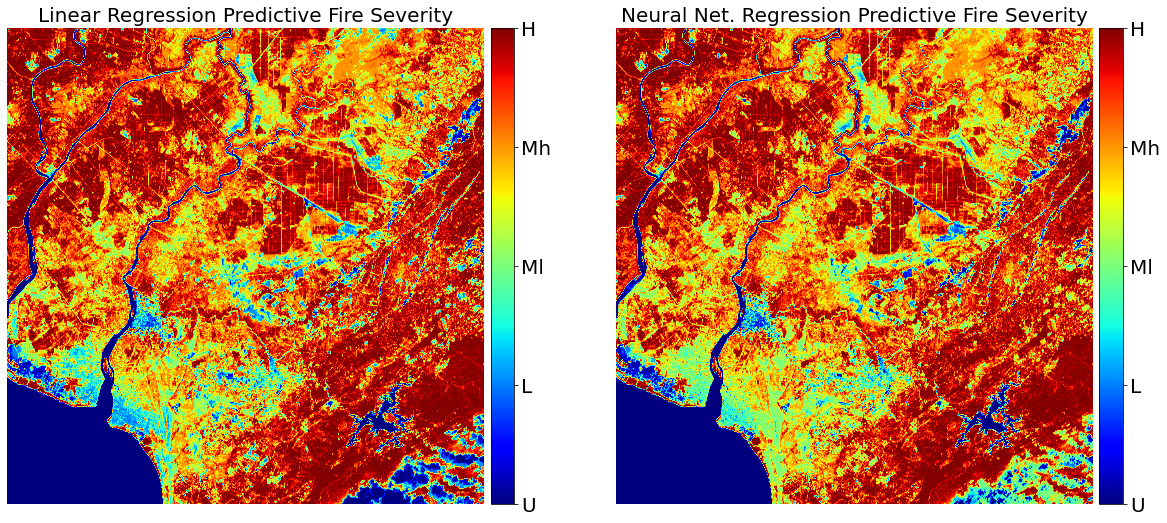

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import warnings

from osgeo import gdal
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm.auto import tqdm

warnings.filterwarnings('ignore')

# Reading images

image_t1 = gdal.Open('./Images/msavi_t1.tif')
image_t2 = gdal.Open('./Images/msavi_t2.tif')
image_t3 = gdal.Open('./Images/msavi_t3.tif')

# Reading image parameters

img_proj = image_t1.GetProjection()
geotransform = image_t1.GetGeoTransform()
img_height = image_t1.RasterYSize
img_width = image_t1.RasterXSize

# Image tiling parameters

tile_size = int(img_height/10)
row_num = int(img_height/tile_size)
column_num = int(img_width/tile_size)
tile_num = int(row_num*column_num)

band_t1 = image_t1.GetRasterBand(1)
band_t2 = image_t2.GetRasterBand(1)
band_t3 = image_t3.GetRasterBand(1)

veg_index_t1 = band_t1.ReadAsArray()
veg_index_t2 = band_t2.ReadAsArray()
veg_index_t3 = band_t3.ReadAsArray()

# Loading regression models

feature_1 = 'MSAVI_T1'
feature_2 = 'MSAVI_T2'
feature_3 = 'MSAVI_T3'

l_reg = pickle.load(open('./Models/msavi_l_reg_model.sav', 'rb'))
nn_reg = pickle.load(open('./Models/msavi_nn_reg_5h_model.sav', 'rb'))

print('Tiling image...')

t1_image_row = np.empty((column_num,tile_size,tile_size))
t2_image_row = np.empty((column_num,tile_size,tile_size))
t3_image_row = np.empty((column_num,tile_size,tile_size))
t1_image_tiles = np.empty((tile_num,tile_size,tile_size))
t2_image_tiles = np.empty((tile_num,tile_size,tile_size))
t3_image_tiles = np.empty((tile_num,tile_size,tile_size))

for i in tqdm(range(row_num)):
    for j in range(column_num):
        t1_image_row[j,:,:] = veg_index_t1[i*tile_size:i*tile_size+tile_size,j*tile_size:j*tile_size+tile_size]
        t2_image_row[j,:,:] = veg_index_t2[i*tile_size:i*tile_size+tile_size,j*tile_size:j*tile_size+tile_size]
        t3_image_row[j,:,:] = veg_index_t3[i*tile_size:i*tile_size+tile_size,j*tile_size:j*tile_size+tile_size]
    t1_image_tiles[i*column_num:i*column_num+column_num] = t1_image_row
    t2_image_tiles[i*column_num:i*column_num+column_num] = t2_image_row
    t3_image_tiles[i*column_num:i*column_num+column_num] = t3_image_row

del t1_image_row, t2_image_row, t3_image_row

# Regression analysis

print('Regression analysis...')

dBAIS2_l_reg_output = np.empty((tile_num,tile_size,tile_size))
dBAIS2_nn_reg_output = np.empty((tile_num,tile_size,tile_size))

for tile in tqdm(range(tile_num)):
    x_train_1 = np.reshape(t1_image_tiles[tile], (tile_size**2))
    x_train_2 = np.reshape(t2_image_tiles[tile], (tile_size**2))
    x_train_3 = np.reshape(t3_image_tiles[tile], (tile_size**2))

    veg_index_dict = {feature_1: x_train_1, feature_2: x_train_2, feature_3: x_train_3}
    veg_index_df = pd.DataFrame(veg_index_dict)

    l_reg_output = l_reg.predict(veg_index_df)
    dBAIS2_l_reg_output[tile] = np.reshape(l_reg_output, (tile_size, tile_size))

    nn_reg_output = nn_reg.predict(veg_index_df)
    dBAIS2_nn_reg_output[tile] = np.reshape(nn_reg_output, (tile_size, tile_size))

del veg_index_dict, veg_index_df, t1_image_tiles, t2_image_tiles, t3_image_tiles

print('Regression analysis completed...')

print('Merging output image tiles...')

dBAIS2_l_reg_predict = np.empty((img_height,img_width))
dBAIS2_nn_reg_predict = np.empty((img_height,img_width))

l_image_line = np.empty((column_num,tile_size,tile_size))
l_array_line = np.empty((tile_size,img_width))
nn_image_line = np.empty((column_num,tile_size,tile_size))
nn_array_line = np.empty((tile_size,img_width))

for i in tqdm(range(row_num)):
    l_image_line = dBAIS2_l_reg_output[i*column_num:(i+1)*column_num]
    nn_image_line = dBAIS2_nn_reg_output[i*column_num:(i+1)*column_num]
    for j in range(column_num):
        l_array_line[:,j*tile_size:j*tile_size+tile_size] = l_image_line[j]
        nn_array_line[:,j*tile_size:j*tile_size+tile_size] = nn_image_line[j]
    dBAIS2_l_reg_predict[i*tile_size:i*tile_size+tile_size,0:(i+1)*column_num*tile_size] = l_array_line
    dBAIS2_nn_reg_predict[i*tile_size:i*tile_size+tile_size,0:(i+1)*column_num*tile_size] = nn_array_line

del l_image_line, l_array_line, nn_image_line, nn_array_line, dBAIS2_l_reg_output, dBAIS2_nn_reg_output

print('Writing prediction images to files...')

# Setting neural network regression prediction output file path and file name

nn_reg_name = './Prediction_Output/nn_reg_predictive_dbais2.tif'
nn_reg_raster = gdal.GetDriverByName("GTiff").Create(nn_reg_name, img_width, img_height, 1, gdal.GDT_Float32)
nn_reg_raster.GetRasterBand(1).WriteArray(dBAIS2_nn_reg_predict)

# Updating neural network regression prediction output image georeference

nn_reg_raster.SetGeoTransform(geotransform)
nn_reg_raster.SetProjection(img_proj)
nn_reg_raster.FlushCache()

nn_reg_raster = None

# # Setting linear regression prediction output file path and file name

# l_reg_name = './Prediction_Output/l_reg_predictive_dbais2.tif'
# l_reg_raster = gdal.GetDriverByName("GTiff").Create(l_reg_name, img_width, img_height, 1, gdal.GDT_Float32)
# l_reg_raster.GetRasterBand(1).WriteArray(dBAIS2_l_reg_predict)

# # Updating linear regression prediction output image georeference

# l_reg_raster.SetGeoTransform(geotransform)
# l_reg_raster.SetProjection(img_proj)
# l_reg_raster.FlushCache()

# l_reg_raster = None

print('Writing image files completed...')

print('Classifying fire severity for visualization...')

fire_severity_classes = [0.1, 0.27, 0.44, 0.66]
usgs_fire_severity_class = ['U', 'L', 'Ml', 'Mh', 'H']

l_reg_fire_severity = np.digitize(dBAIS2_l_reg_predict, bins=fire_severity_classes)
nn_reg_fire_severity = np.digitize(dBAIS2_nn_reg_predict, bins=fire_severity_classes)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

ax[0].set_title('Linear Regression Predictive Fire Severity', fontsize=20)
ax[0].axis('off')
divider0 = make_axes_locatable(ax[0])
cax0 = divider0.append_axes("right", size="5%", pad=0.1)
cbar0 = plt.colorbar(ax[0].imshow(l_reg_fire_severity+1, cmap='jet'), cax=cax0)
cbar0
cbar0.ax.tick_params(labelsize=20)
cbar0.set_ticks([x for x in range(1, len(usgs_fire_severity_class)+1)])
tick_labels0 = usgs_fire_severity_class
cbar0.set_ticklabels(tick_labels0)

ax[1].set_title('Neural Net. Regression Predictive Fire Severity', fontsize=20)
ax[1].axis('off')
divider1 = make_axes_locatable(ax[1])
cax1 = divider1.append_axes("right", size="5%", pad=0.1)
cbar1 = plt.colorbar(ax[1].imshow(nn_reg_fire_severity+1, cmap='jet'), cax=cax1)
cbar1
cbar1.ax.tick_params(labelsize=20)
cbar1.set_ticks([x for x in range(1, len(usgs_fire_severity_class)+1)])
tick_labels1 = usgs_fire_severity_class
cbar1.set_ticklabels(tick_labels1)

plt.show()